In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import datetime
import pandas_datareader.data as web
import quandl

def gen_stock_info(ticker, start, end):
    stock_df = quandl.get(''.join(['WIKI/', ticker]), start_date=start, end_date=end)
    return stock_df.iloc[:,7:]  #only need some columns


def add_Moving_Ave(stock_df):
    ma_list = ['ma20', 'ma60', 'ma120']
    window_list = [20, 60, 120]
    for ma, window_ in zip(ma_list, window_list):
        stock_df[ma] = stock_df['Close'].rolling(window=window_).mean()
    return stock_df
    
    
def add_STD(stock_df):
    std_list = ['std_20']
    window_list = [20]
    for std, window_ in zip(std_list, window_list):
        stock_df[std] = stock_df['Close'].rolling(window=window_).std()
    return stock_df


def draw_stock(stock_df, window_=365):

    plt.figure(figsize=(20,10))
    plt.plot(stock_df.index[-window_:],stock_df.Close[-window_:],label='Close')
    plt.plot(stock_df.index[-window_:],stock_df.ma20[-window_:],label='ma20')
    plt.plot(stock_df.index[-window_:],stock_df.ma60[-window_:],label='ma60')
    plt.plot(stock_df.index[-window_:],stock_df.ma120[-window_:],label='ma120')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [2]:
def get_positions(stock_df):

    stock_df['positions']='None'
    stock_df.loc[stock_df[stock_df['Close'] > stock_df['ma20']+ 2*stock_df['std_20']].index,['positions']]='Short'
    stock_df.loc[stock_df[stock_df['Close'] < stock_df['ma20']- 2*stock_df['std_20']].index,['positions']]='Long'

    stock_df['position_change']='None'
    for i in range(1,len(stock_df.index)):
        if ((stock_df.iloc[i-1]['positions']=='None') and (stock_df.iloc[i]['positions']=='Long')):
            stock_df.loc[stock_df.index[i],['position_change']]='None to Long'
        elif ((stock_df.iloc[i-1]['positions']=='None') and (stock_df.iloc[i]['positions']=='Short')):
            stock_df.loc[stock_df.index[i],['position_change']]='None to Short'
        elif ((stock_df.iloc[i-1]['positions']=='Long') and (stock_df.iloc[i]['positions']=='None')):
            stock_df.loc[stock_df.index[i],['position_change']]='Long to None'
        elif ((stock_df.iloc[i-1]['positions']=='Short') and (stock_df.iloc[i]['positions']=='None')):
            stock_df.loc[stock_df.index[i],['position_change']]='Short to None'
  
    return stock_df

def draw_positions(stock_df, window_ = 365):
            
    plt.figure(figsize=(20,10))
    plt.plot(stock_df.index[-window_:],stock_df.Close[-window_:],label='Close')
    plt.plot(stock_df.index[-window_:],stock_df.ma20[-window_:],label='ma20')
    plt.plot(stock_df.iloc[-window_:][stock_df.iloc[-window_:]['position_change']=='None to Long'].index,stock_df.iloc[-window_:][stock_df.iloc[-window_:]['position_change']=='None to Long'].Close,'^',label='None to Long')
    plt.plot(stock_df.iloc[-window_:][stock_df.iloc[-window_:]['position_change']=='Long to None'].index,stock_df.iloc[-window_:][stock_df.iloc[-window_:]['position_change']=='Long to None'].Close,'.',label='Long to None')

    plt.plot(stock_df.iloc[-window_:][stock_df.iloc[-window_:]['position_change']=='None to Short'].index,stock_df.iloc[-window_:][stock_df.iloc[-window_:]['position_change']=='None to Short'].Close,'v',label='None to Short')
    plt.plot(stock_df.iloc[-window_:][stock_df.iloc[-window_:]['position_change']=='Short to None'].index,stock_df.iloc[-window_:][stock_df.iloc[-window_:]['position_change']=='Short to None'].Close,'.',label='Short to None')

    plt.fill_between(stock_df.index[-window_:],stock_df.ma20[-window_:]-stock_df.std_20[-window_:],stock_df.ma20[-window_:]+stock_df.std_20[-window_:], alpha=0.4)
    plt.legend(loc='best')

    plt.grid()
    plt.show()

def simulate_algo(stock_df, init_cash = 1000):
    
    stock_df['Cash']=0  #actually it means the cash flow at that time
    stock_df.at[stock_df.index[0],'Cash']=init_cash
    stock_df['Port_val']=0
    stock_df['Total_asset']=0
    stock_df.at[stock_df.index[0],'Total_asset'] = stock_df.iloc[0]['Cash']+stock_df.iloc[0]['Port_val']
    stock_df['Net_profit']=0

    for i in range(1,len(stock_df.index)):
            #if there is no change in our portfolio
        if ((stock_df.iloc[i-1]['positions']=='None') and (stock_df.iloc[i]['positions']=='None')):
            stock_df.loc[stock_df.index[i],'Cash']= stock_df.loc[stock_df.index[i-1],'Cash']
            stock_df.loc[stock_df.index[i],'Port_val']= 0
            stock_df.loc[stock_df.index[i],'Total_asset']= stock_df.loc[stock_df.index[i-1],'Total_asset']
            stock_df.loc[stock_df.index[i],'Net_profit']= 0

            #if we hold the same long position from the previous, only Port_val may change
        elif ((stock_df.iloc[i-1]['positions']=='Long') and (stock_df.iloc[i]['positions']=='Long')):
            stock_df.loc[stock_df.index[i],'Cash']= stock_df.loc[stock_df.index[i-1],'Cash']
            stock_df.loc[stock_df.index[i],'Port_val']= stock_df.loc[stock_df.index[i],'Close']
            stock_df.loc[stock_df.index[i],'Total_asset']= stock_df.loc[stock_df.index[i],'Cash'] + stock_df.loc[stock_df.index[i],'Port_val']
            stock_df.loc[stock_df.index[i],'Net_profit']= stock_df.loc[stock_df.index[i],'Total_asset'] - stock_df.loc[stock_df.index[i-1],'Total_asset']


        elif ((stock_df.iloc[i-1]['positions']=='Short') and (stock_df.iloc[i]['positions']=='Short')):
            stock_df.loc[stock_df.index[i],'Cash']= stock_df.loc[stock_df.index[i-1],'Cash']
            stock_df.loc[stock_df.index[i],'Port_val']= -stock_df.loc[stock_df.index[i],'Close']
            stock_df.loc[stock_df.index[i],'Total_asset']= stock_df.loc[stock_df.index[i],'Cash'] + stock_df.loc[stock_df.index[i],'Port_val']
            stock_df.loc[stock_df.index[i],'Net_profit']= stock_df.loc[stock_df.index[i],'Total_asset'] - stock_df.loc[stock_df.index[i-1],'Total_asset']


        elif ((stock_df.iloc[i-1]['positions']=='None') and (stock_df.iloc[i]['positions']=='Long')):
            stock_df.loc[stock_df.index[i],'Cash']= stock_df.loc[stock_df.index[i-1],'Cash'] - stock_df.loc[stock_df.index[i],'Close']
            stock_df.loc[stock_df.index[i],'Port_val']= stock_df.loc[stock_df.index[i],'Close']
            stock_df.loc[stock_df.index[i],'Total_asset']= stock_df.loc[stock_df.index[i],'Cash'] + stock_df.loc[stock_df.index[i],'Port_val']
            stock_df.loc[stock_df.index[i],'Net_profit']= stock_df.loc[stock_df.index[i],'Total_asset'] - stock_df.loc[stock_df.index[i-1],'Total_asset']

        elif ((stock_df.iloc[i-1]['positions']=='None') and (stock_df.iloc[i]['positions']=='Short')):
            stock_df.loc[stock_df.index[i],'Cash']= stock_df.loc[stock_df.index[i-1],'Cash'] + stock_df.loc[stock_df.index[i],'Close']
            stock_df.loc[stock_df.index[i],'Port_val']= -stock_df.loc[stock_df.index[i],'Close']
            stock_df.loc[stock_df.index[i],'Total_asset']= stock_df.loc[stock_df.index[i],'Cash'] + stock_df.loc[stock_df.index[i],'Port_val']
            stock_df.loc[stock_df.index[i],'Net_profit']= stock_df.loc[stock_df.index[i],'Total_asset'] - stock_df.loc[stock_df.index[i-1],'Total_asset']

        elif ((stock_df.iloc[i-1]['positions']=='Long') and (stock_df.iloc[i]['positions']=='None')):
            stock_df.loc[stock_df.index[i],'Cash']= stock_df.loc[stock_df.index[i-1],'Cash'] + (stock_df.loc[stock_df.index[i],'Close'] -stock_df.loc[stock_df.index[i-1],'Close'])
            stock_df.loc[stock_df.index[i],'Port_val']= 0
            stock_df.loc[stock_df.index[i],'Total_asset']= stock_df.loc[stock_df.index[i],'Cash']
            stock_df.loc[stock_df.index[i],'Net_profit']= stock_df.loc[stock_df.index[i],'Total_asset'] - stock_df.loc[stock_df.index[i-1],'Total_asset']

        elif ((stock_df.iloc[i-1]['positions']=='Short') and (stock_df.iloc[i]['positions']=='None')):
            stock_df.loc[stock_df.index[i],'Cash']= stock_df.loc[stock_df.index[i-1],'Cash'] - (stock_df.loc[stock_df.index[i],'Close'] - stock_df.loc[stock_df.index[i-1],'Close'])
            stock_df.loc[stock_df.index[i],'Port_val']= 0
            stock_df.loc[stock_df.index[i],'Total_asset']= stock_df.loc[stock_df.index[i],'Cash']
            stock_df.loc[stock_df.index[i],'Net_profit']= stock_df.loc[stock_df.index[i],'Total_asset'] - stock_df.loc[stock_df.index[i-1],'Total_asset']

    stock_df['Cum_profit']=stock_df['Net_profit'].cumsum()
    return stock_df


def draw_result_of_sim(stock_df):
    plt.figure(figsize=(20,10))
    plt.plot(stock_df['Close'], label='Close')
    plt.plot(stock_df['Cum_profit'],label='Cumulative_profit')
    plt.plot(stock_df['Net_profit'],label='Net_profit')
    plt.legend(loc='best')
    plt.show()

def draw_return_dist(stock_df):
    dailyreturn = np.log(stock_df.Close)-np.log(stock_df.Close.shift(1))
    day_ret = np.array(dailyreturn[1:])
    import seaborn as sns
    from scipy import stats
    sns.distplot(day_ret, kde=True, rug=True, fit=stats.norm)
    

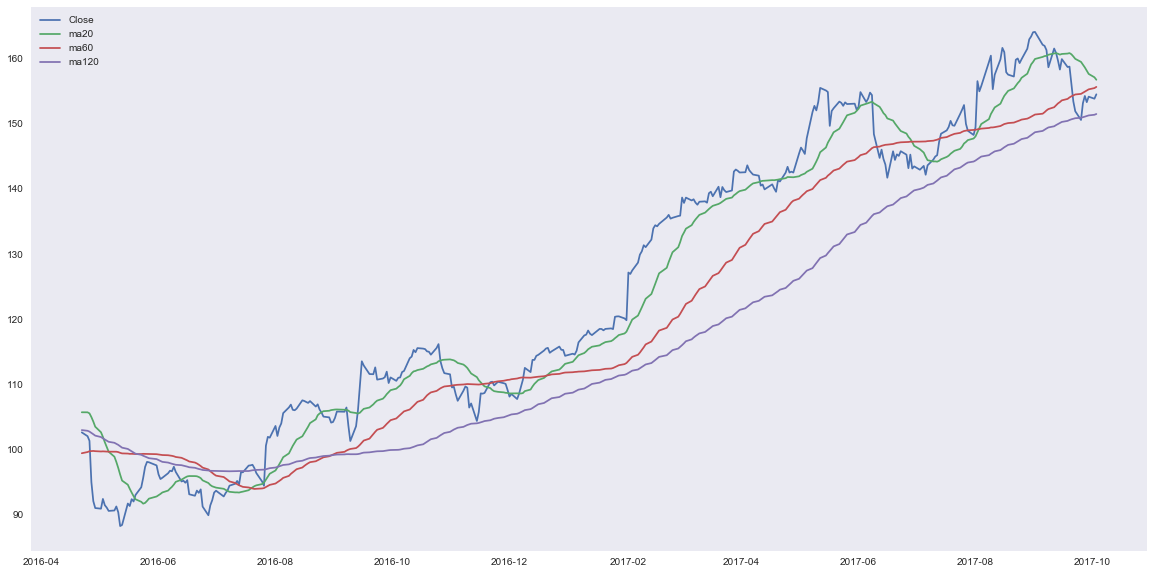

In [5]:
stock_df = gen_stock_info('AAPL', '2010-01-01', '2017-10-03')
stock_df.columns = ['Open','High','Low','Close','Volume']
stock_df = add_Moving_Ave(stock_df)
stock_df = add_STD(stock_df)

draw_stock(stock_df, 365)

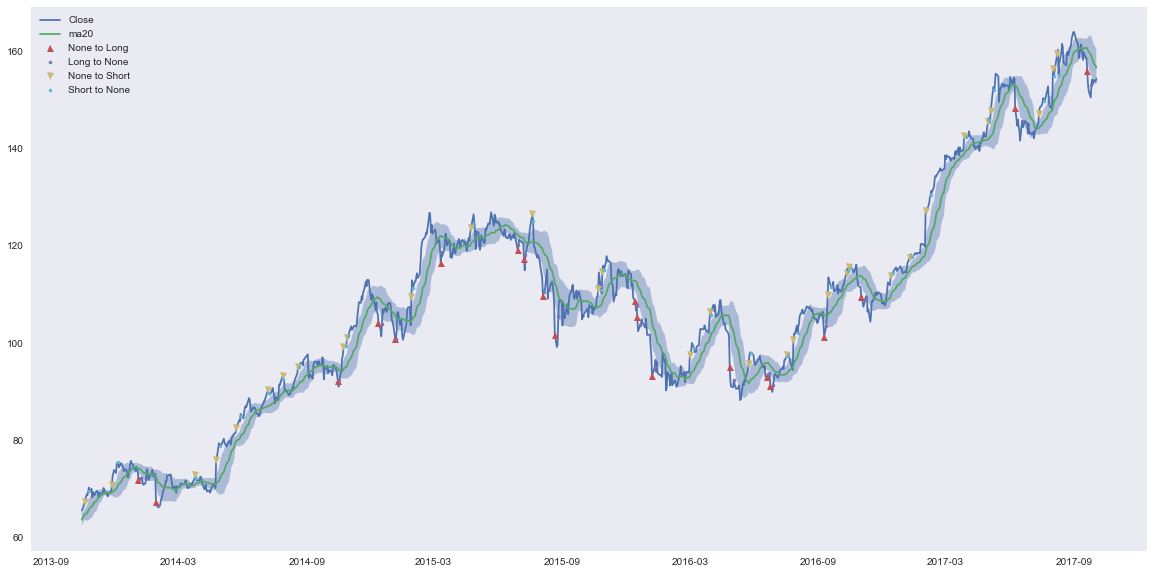

In [6]:
stock_df = get_positions(stock_df)
draw_positions(stock_df, 1000)

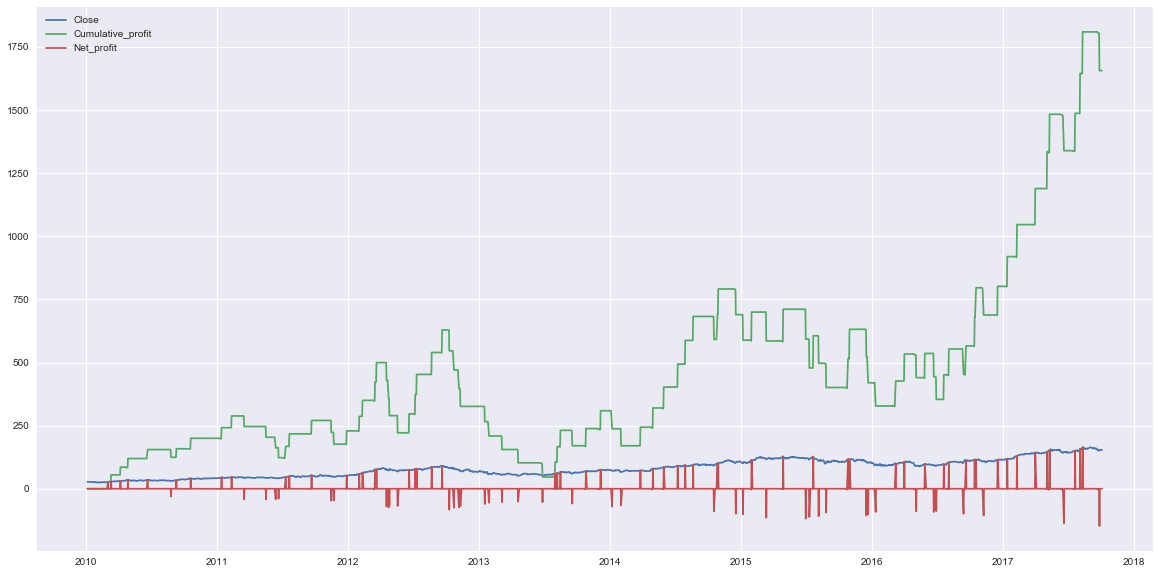

In [7]:
stock_df = simulate_algo(stock_df)
draw_result_of_sim(stock_df)

/Users/Sungwookhong/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


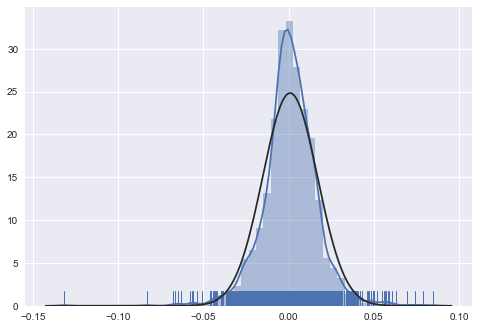

In [8]:
draw_return_dist(stock_df)